# Building fully vectorized ANN with backpropagation tested with MNIST data
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

More detail, please check: http://yann.lecun.com/exdb/mnist/

It has also been integrated into sklean package, so it can be directly imported.

(1797, 8, 8)
(1797, 64)


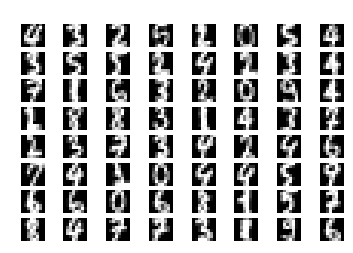

In [204]:
# loading MNIST data
from sklearn.datasets import load_digits
digits = load_digits()
# digits image data which has been converted into three dimensional array
print(digits.images.shape)
# data has been concantenated into a vector by order
print(digits.data.shape)

import numpy as np
import matplotlib.pyplot as plt
_, axs = plt.subplots(8,8)
ran_img = np.random.choice(range(digits.images.shape[0]), 64)
plt.gray()
for i in range(8):
    for j in range(8):
        axs[i,j].axis('off')
        axs[i,j].matshow(digits.images[ran_img[i*8+j]])
plt.show()

### Preprocessing data
* Standardize x
* Split training and testing set
* Create dummy output for classification

In [205]:
# standardize data into zscore
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

# create training and testing set
from sklearn.model_selection import train_test_split
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# convert y value into vector of zeros and one, dummy variable
import numpy as np
def vectorize_y(y):
    y_vec = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vec[i,y[i]] = 1
    return y_vec
y_train = vectorize_y(y_train)
y_test  = vectorize_y(y_test)
print(X_train.shape)
print(y_train.shape)

(1078, 64)
(1078, 10)


### Define ANN functions

#### Weights, $w_i$, between input layer $l_{i-1}$ and output layer $l_{i}$ has size of $n_{i}\times n_{i-1} $
#### Bias, $b_i$, betwen input layer $l_{i-1}$ and output layer $l_{i}$ has size of $n_{i}\times 1 $

In [235]:
# define NN structure
def sigmoid_activation(X, w, b):
    X_theta = X @ w.T + b.T
    f_X = 1/(1 + np.exp(-X_theta))
    f_deriv = f_X * (1 - f_X)
    return f_X, f_deriv

# define function for calculate derivatives
def sigmoid_deriv(X, w, b):
    f_X, X_theta = sigmoid_activation(X, w, b)
    return f_X * (1 - f_X), X_theta

# define function for initializing weights and bias
def weight_initialization(nn_structure):
    W = {}
    b = {}
    for sl in range(1, len(nn_structure)):
        W[sl] = np.random.random_sample((nn_structure[sl], nn_structure[sl - 1]))
        b[sl] = np.random.random_sample((nn_structure[sl],))
    return W, b

# define function for creating weight and bias updates
def delta_initialization(nn_structure):
    delta_W = {}
    delta_b = {}
    for sl in range(1, len(nn_structure)):
        delta_W[sl] = np.zeros((nn_structure[sl], nn_structure[sl - 1]))
        delta_b[sl] = np.zeros((nn_structure[sl],))
    return delta_W, delta_b

# define function for feedforward
def feed_forward(X, W, b):
    h = {1:X}
    f_deriv = {}
    for sl in range(1, len(W)+1):
        if sl == 1:
            node_in = X
        else:
            node_in = h[sl]
        h[sl+1], f_deriv[sl+1] = sigmoid_activation(node_in, W[sl], b[sl])
    return h, f_deriv

# calculate gradient at output layer
def calculate_gradient_last_layer(y, h_out, f_deriv):
    return -(y - h_out) * f_deriv

# calculate gradient at hidden layers
def calculate_gradient_hidden_layer(delta_plus_1, w_sl, f_deriv_sl):
    return np.dot(delta_plus_1, w_sl) * f_deriv_sl

def train_nn(nn_structure, X, y, iter_num = 3000, alpha = 0.25, lamda = 0.8, penalty_type = None):
    W, b = weight_initialization(nn_structure)
    cnt = 0
    m = len(y)
    mean_residual = []
    J = []
    print("Gradient decent stated for {} iteration".format(iter_num))
    
    while cnt <= iter_num:
        cnt += 1
        if cnt % 1000 == 0:
            print("Finshed {} out of {}".format(cnt, iter_num))
        delta_W, delta_b = delta_initialization(nn_structure)
        delta = {}
        h, f_deriv = feed_forward(X, W, b)

        for sl in range(len(nn_structure), 0, -1):
            if sl == len(nn_structure):
                delta[sl] = calculate_gradient_last_layer(y, h[sl], f_deriv[sl])
                J.append(sum(delta[sl])/m)
                mean_residual.append(np.linalg.norm(y-h[sl])/m)
            else:
                if sl > 1:
                    delta[sl] = calculate_gradient_hidden_layer(delta[sl+1], W[sl], f_deriv[sl])
                # delta updates
                if penalty_type == "L1":
                    r = sum(abs(W[sl]))
                elif penalty_type == "L2":
                    r = sum(np.square(W[sl]))
                elif penalty_type == None:
                    r = 0
                delta_W[sl] += np.dot(delta[sl+1].T, h[sl]) + lamda/m*r
                delta_b[sl] += np.sum(delta[sl+1].T)

        for sl in range(len(nn_structure)-1,0,-1):
            # weights updates
            W[sl] += -alpha * (1.0/2/m * delta_W[sl])
            b[sl] += -alpha * (1.0/2/m * delta_b[sl])
            
    return W, b, mean_residual, J

def predict_nn(W, b, X, nn_structure):
    m = X.shape[0]
    y_hat = np.zeros((m,))
    n_layers = len(nn_structure)
    for i in range(m):
        h, z = feed_forward(X[i,:], W, b)
        y_hat[i] = np.argmax(h[n_layers]) 
    return y_hat

In [236]:
nn_structure = [64, 30, 10]
W, b, residual, cost = train_nn(nn_structure, X=X_train, y=y_train, 
                               iter_num = 30000, alpha = 0.25, penalty_type = None, lamda = 0.1)

Gradient decent stated for 30000 iteration
Finshed 1000 out of 30000
Finshed 2000 out of 30000
Finshed 3000 out of 30000
Finshed 4000 out of 30000
Finshed 5000 out of 30000
Finshed 6000 out of 30000
Finshed 7000 out of 30000
Finshed 8000 out of 30000
Finshed 9000 out of 30000
Finshed 10000 out of 30000
Finshed 11000 out of 30000
Finshed 12000 out of 30000
Finshed 13000 out of 30000
Finshed 14000 out of 30000
Finshed 15000 out of 30000
Finshed 16000 out of 30000
Finshed 17000 out of 30000
Finshed 18000 out of 30000
Finshed 19000 out of 30000
Finshed 20000 out of 30000
Finshed 21000 out of 30000
Finshed 22000 out of 30000
Finshed 23000 out of 30000
Finshed 24000 out of 30000
Finshed 25000 out of 30000
Finshed 26000 out of 30000
Finshed 27000 out of 30000
Finshed 28000 out of 30000
Finshed 29000 out of 30000
Finshed 30000 out of 30000


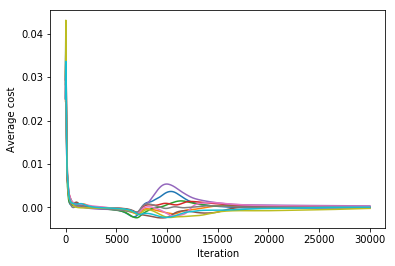

In [237]:
# plt.plot(residual)
plt.plot(cost)
plt.ylabel('Average cost')
plt.xlabel('Iteration')
plt.show()

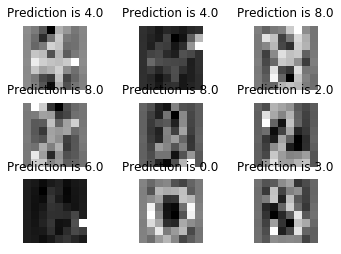

In [238]:
y_hat = predict_nn(W, b, X_test, nn_structure)
_, axs = plt.subplots(3, 3)
# plt.rcParams["figure.figsize"] = (10,20)If 
plt.subplots_adjust(wspace=0.1, hspace=None)
for i in range(3):
    for j in range(3):
        imatrix = np.reshape(X_test[i*3 + j], newshape=[8,8])
        # axs[i,j].gray()
        axs[i,j].matshow(imatrix)
        axs[i,j].axis('off')
        axs[i,j].set_title('Prediction is {}'.format(y_hat[i*3 + j]))
